# Use a the very simple, REINFORCE agent
Just to make sure everything works correctly

In [30]:
%matplotlib inline
from matplotlib import pyplot as plt
from hydronet.rl.tf.env import SimpleEnvironment
from hydronet.rl.rewards.mpnn import MPNNReward
from hydronet.rl.tf.agents import ConstrainedRandomPolicy
from hydronet.rl.tf.networks import GCPNActorNetwork
from hydronet.mpnn.layers import custom_objects
from tf_agents.environments.tf_py_environment import TFPyEnvironment
from tf_agents.replay_buffers.tf_uniform_replay_buffer import TFUniformReplayBuffer
from tf_agents.drivers.dynamic_episode_driver import DynamicEpisodeDriver
from tf_agents.agents.reinforce import reinforce_agent
from pathlib import Path
from tqdm import tqdm
import tensorflow as tf
import pandas as pd
import numpy as np

Configuration

In [2]:
mpnn_path = Path() / '..' / '..' / 'challenge-2' / 'best-model' / 'best_model.h5'

## Make the Environment
Use the energy of the cluster predicted with our MPNN as a reward

In [3]:
model = tf.keras.models.load_model(mpnn_path, custom_objects=custom_objects)
reward = MPNNReward(model)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


In [4]:
env = SimpleEnvironment(maximum_size=20, reward=reward, only_last=False)
tf_env = TFPyEnvironment(env)

## Build the Policies
We are going to compare against a baseline policy that picks random setsp

### Make a Random Policy
Using our random policy that constrains guesses to actions that produce valid graphs.

In [5]:
random_policy = ConstrainedRandomPolicy(
    time_step_spec=tf_env.time_step_spec(),
    action_spec=tf_env.action_spec()
)

### Make the Reinforce Agent
Use the `GCPNActorNetwork` to predict actions

In [6]:
actor_net = GCPNActorNetwork(tf_env.observation_spec(), tf_env.action_spec(), tf_env.reset(), num_messages=8, node_features=32)

In [7]:
optimizer = tf.keras.optimizers.Adam(1e-4, clipvalue=0.1)

In [8]:
tf_agent = reinforce_agent.ReinforceAgent(
    tf_env.time_step_spec(),
    tf_env.action_spec(),
    actor_network=actor_net,
    optimizer=optimizer,
    normalize_returns=True
)
tf_agent.initialize()

## Drive it to Make some Data
Use the TFUniformReplyBuffer to keep track of data

In [9]:
buffer = TFUniformReplayBuffer(
    tf_agent.collect_data_spec,
    batch_size=1,
    max_length=1024,
)

In [10]:
driver = DynamicEpisodeDriver(tf_env, tf_agent.collect_policy, [buffer.add_batch], num_episodes=1)

Measure the average return

In [11]:
def compute_avg_return(environment, policy, num_episodes=10):
    total_return = 0.0
    for _ in range(num_episodes):
        time_step = environment.reset()
        episode_return = 0.0

        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
        total_return += episode_return

    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]

Get the average return for a random policy

In [12]:
random_return = compute_avg_return(tf_env, random_policy, 32)
print(f'Random return: {random_return:.1f}')

/home/lward/miniconda3/envs/hydronet/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:588: UserWarning: Input dict contained keys ['n_waters', 'n_atoms', 'n_bonds', 'bond_graph_indices'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


Random return: 294.3


In [13]:
# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(tf_env, tf_agent.policy, 1)
returns = []

train_loss = None
losses = []
pbar = tqdm(range(512))
for step in pbar:
    # Collect a few episodes using collect_policy and save to the replay buffer.
    buffer.clear()
    init_ts = tf_env.reset()
    final_ts, _ = driver.run(init_ts)

    # Use data from the buffer and update the agent's network.
    last_weights = actor_net.get_weights()
    experience = buffer.gather_all()
    try:
        train_loss = tf_agent.train(experience)
    except tf.errors.InvalidArgumentError as e:
        print(f'Encountered an error, resetting weights to last iteration: {e}')
        actor_net.set_weights(last_weights)
        break
    losses.append(train_loss.loss.numpy())

    # Compute the return of the greedy policy
    avg_return = compute_avg_return(tf_env, tf_agent.policy, 1)
    returns.append(avg_return)
    
    # Update the progress bar
    pbar.set_description(f'loss: {train_loss.loss:.2e} - return: {avg_return:.1f}')

  0%|          | 0/512 [00:00<?, ?it/s]

Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=True)` instead.


loss: 7.36e-01 - return: 241.0:  99%|█████████▉| 508/512 [12:43<00:06,  1.50s/it] 

Encountered an error, resetting weights to last iteration: Loss is inf or nan : Tensor had NaN values [Op:CheckNumerics]


In [14]:
agent_return = compute_avg_return(tf_env, tf_agent.collect_policy, 32)
print(f'Agent return with randomized policy: {agent_return:.1f}')

Agent return with randomized policy: 284.6


## Save the Model and Training Performance
So we can analyze them later

In [15]:
tf.saved_model.save(actor_net, 'actor_net')


FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.



FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.


INFO:tensorflow:Assets written to: actor_net/assets


INFO:tensorflow:Assets written to: actor_net/assets


In [16]:
train_info = pd.DataFrame({
    'loss': losses,
    'return': returns
})
train_info.to_csv('train_info.csv', index=False)

## Make a Simple Plot
See if the return is increasing over time

Text(0, 0.5, 'Return')

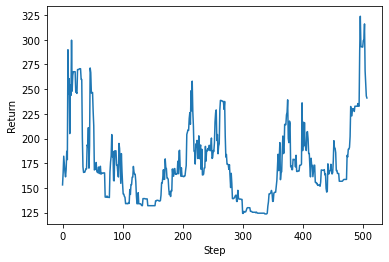

In [17]:
fig, ax = plt.subplots()

ax.plot(train_info['return'])
ax.set_xlabel('Step')
ax.set_ylabel('Return')

0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
         ...   
503    1.937037
504    1.937037
505    1.937037
506    1.937037
507    1.089396
Name: loss, Length: 508, dtype: float64

Text(0, 0.5, 'Loss')

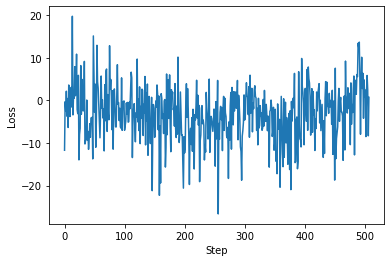

In [48]:
fig, ax = plt.subplots()

ax.plot(train_info['loss'])
ax.set_xlabel('Step')
ax.set_ylabel('Loss')

Plot some trajectories

In [18]:
def get_trajectories(environment, policy, num_episodes=10):
    """Get trajectory of energy wrt step
    
    Args:
        environment: Water cluster environment
        policy: Policy to execute
    Returns:
        List of trajectories
    """
    output = []
    
    for _ in range(num_episodes):
        time_step = environment.reset()
        traj = []
        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            traj.append(float(-1 * time_step.reward.numpy() * time_step.observation['n_atoms'].numpy()))
        output.append(traj)

    return output

In [19]:
%%time
rl_traj = get_trajectories(tf_env, tf_agent.collect_policy, 32)

/home/lward/miniconda3/envs/hydronet/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:588: UserWarning: Input dict contained keys ['n_waters', 'n_atoms', 'n_bonds', 'bond_graph_indices'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


CPU times: user 30.3 s, sys: 564 ms, total: 30.9 s
Wall time: 29.1 s


In [20]:
%%time
greedy_traj = get_trajectories(tf_env, tf_agent.policy, 1)

CPU times: user 863 ms, sys: 20.2 ms, total: 883 ms
Wall time: 832 ms


In [21]:
%%time
random_traj = get_trajectories(tf_env, random_policy, 32)

CPU times: user 11.1 s, sys: 255 ms, total: 11.3 s
Wall time: 10.5 s


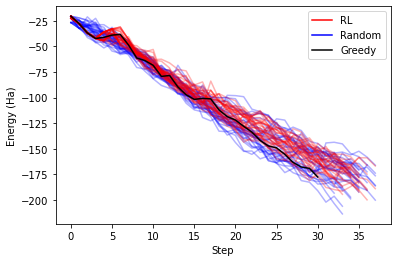

In [37]:
fig, ax = plt.subplots()

for t in random_traj:
    ax.plot(t, color='b', alpha=0.3)
for t in rl_traj:
    ax.plot(t, color='r', alpha=0.3)
ax.plot([], color='r', label='RL')
ax.plot([], color='b', label='Random')
ax.plot(greedy_traj[0], 'k', label='Greedy')

ax.set_xlabel('Step')
ax.set_ylabel('Energy (Ha)')
ax.legend()

Text(0, 0.5, 'Count')

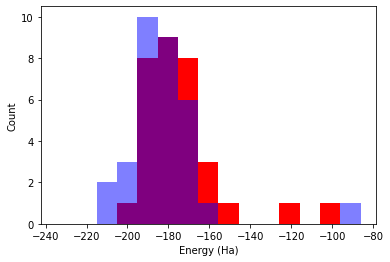

In [35]:
fig, ax = plt.subplots()

best_energy_rl = [min(x) for x in rl_traj]
best_energy_rand = [min(y) for y in random_traj]
bins = np.linspace(
    min(best_energy_rand + best_energy_rl) * 1.1,
    max(best_energy_rand + best_energy_rl) * 0.9,
    16
)

ax.hist(best_energy_rl, bins=bins, color='r', label='RL')
ax.hist(best_energy_rand, bins=bins, alpha=0.5, color='b', label='Random')

ax.set_xlabel('Energy (Ha)')
ax.set_ylabel('Count')